# Pooling parameters

Consider an inference problem where we have measurements of the same biological process for a number of individuals, e.g. the growth of a tumour. Let's assume that this process is described by a logistic growth

\begin{equation*}
    f(t | \theta) = \frac{k}{1 + (k / f_0 - 1) e^{-r t}},
\end{equation*}

where $\theta = (f_0, r, k)$. Here $f_0$ is the initial size of the tumour $f(t=0, \theta) = f_0$, $r$ is the growth rate, and $k$ is the maximal size of the tumour. Let's denote the measured time series of the $n$ individuals by $\{D_1, \ldots , D_n\}$, where $D_i$ is the tumour volume at the measured time points of individual $i$.

From a biological perspective it makes sense to expect that the tumour growth is captured by the same structural model $f$ across individuals. However, it can also be expected that there are significant biological differences between the indiviudals. As a result, it seems feasible to construct independent likelihoods for each in individual and solve the respective inverse problem independently. This results in an independent set of model parameters $(\theta _i, \sigma _i)$ for each individual. Here $\sigma _i$ are the parameters associated to the error model that is needed for the construction of the likelihood.

However, in some biological settings the available data per individual may be quite sparse, and the accuracy of the inference would greatly improve if we could leverage the population information. For example, we may expect that the noise model across individuals may be identical $\sigma := \sigma _1 = \ldots = \sigma _n$, since the measurement process was identical for all individuals. In other words, *pooling* the noise parameter $\sigma _i$ across individuals may be benificial for the inference.

## Illustration

Let us illustrate this idea of pooling by synthesizing data for a number of individuals. We will choose the above introduced logistic growth model $f$ and a Gaussian error. To mimick the intuition of biological differences, but identical measurement noise aross individuals, we will slightly vary the structural model parameters $\theta $ and keep the noise parameter $\sigma $ the same across indiviudals.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pints
import pints.plot
import pints.toy

# Define model parameters
parameters = [
    [2, 0.015, 500, 10],
    [1.5, 0.02, 500, 10],
    [5, 0.01, 500, 10],
    [3, 0.008, 500, 10]]

# Generate data
data = []
for params in parameters:
    # Get parameters of individual
    f_0, r, k, sigma = params

    # Instantiate logistic growth model with f(t=0) = f_0
    model = pints.toy.LogisticModel(initial_population_size=f_0)

    # Generate data
    times = np.linspace(start=0, stop=1000, num=5)
    model_output = model.simulate(parameters=[r, k], times=times)
    gauss = np.random.normal(loc=0.0, scale=1.0, size=len(model_output))
    observations = model_output + sigma * gauss

    # Save data as time-observation tuples
    data += [np.vstack([times, observations])]

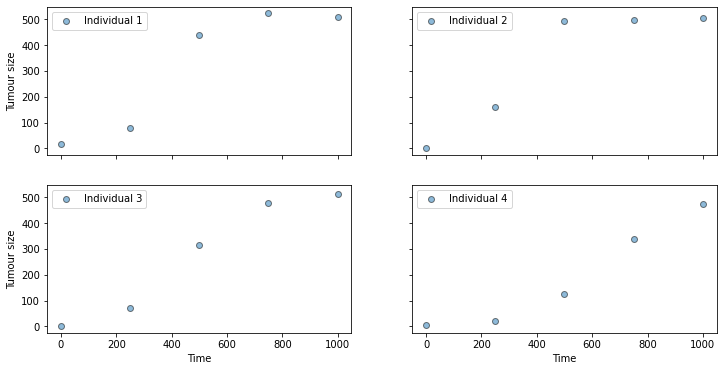

In [2]:
# Create figure
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(12, 6))

# Plot generated data
d = data[0]
ax[0, 0].scatter(d[0, :], d[1, :], label='Individual 1', edgecolors='black', alpha=0.5)
d = data[1]
ax[0, 1].scatter(d[0, :], d[1, :], label='Individual 2', edgecolors='black', alpha=0.5)
d = data[2]
ax[1, 0].scatter(d[0, :], d[1, :], label='Individual 3', edgecolors='black', alpha=0.5)
d = data[3]
ax[1, 1].scatter(d[0, :], d[1, :], label='Individual 4', edgecolors='black', alpha=0.5)

# Create X and Y axis title
ax[0, 0].set_ylabel('Tumour size')
ax[1, 0].set_ylabel('Tumour size')
ax[1, 0].set_xlabel('Time')
ax[1, 1].set_xlabel('Time')

# Create legend
ax[0, 0].legend()
ax[0, 1].legend()
ax[1, 0].legend()
ax[1, 1].legend()

# Show figure
plt.show()

**Figure 1:** Synthesised data for 4 individuals with varying structural model parameters, but identical noise parameters.

## Independent inference of parameters

Let us first infer the model parameters of each individual separately. For simplicity we fix the initial tumour volume and the maximal tumour size to the correct parameter value and only infer the growth rate $r$.

To this end we instantiate the log-likelihoods for the individuals separately.

In [3]:
# Create a wrapper for the logistic model
class Model(pints.ForwardModel):
    def __init__(self, f_0, k):
        self._k = k
        self._model = pints.toy.LogisticModel(initial_population_size=f_0)

    def simulate(self, parameters, times):
        return self._model.simulate(parameters=[parameters[0], self._k], times=times)
    
    def simulateS1(self, parameters, times):
        y, dy = self._model.simulateS1(parameters=[parameters[0], self._k], times=times)
        return y, dy[:, :1]

    def n_parameters(self):
        return 1

# Create loglikelihoods for the individuals
log_likelihoods = []
problems = []
for idx, params in enumerate(parameters):
    # Instantiate model
    f_0, _, k, _ = params
    model = Model(f_0, k)

    # Create log-likelihood
    d = data[idx]
    problem = pints.SingleOutputProblem(model=model, times=d[0, :], values=d[1, :])
    log_likelihood = pints.GaussianLogLikelihood(problem)

    # Save log_liklihood
    log_likelihoods += [log_likelihood]
    problems += [problem]

Using the instantiated likelihoods, we can now sample from them using any MCMC routine. Below we run 3 MCMC routines for each individual and display the respective quantitative and visual diagnostics.

### Infer parameters exemplary for indiviudal 2

### Individual 2

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess     ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  ------  --------------
r        0.02    0.00    0.02    0.02   0.02   0.02   0.02     1.01    638.32  76.92
sigma    5.04    4.08    1.92    2.96   4.00   5.61   14.90    1.06    138.45  16.68


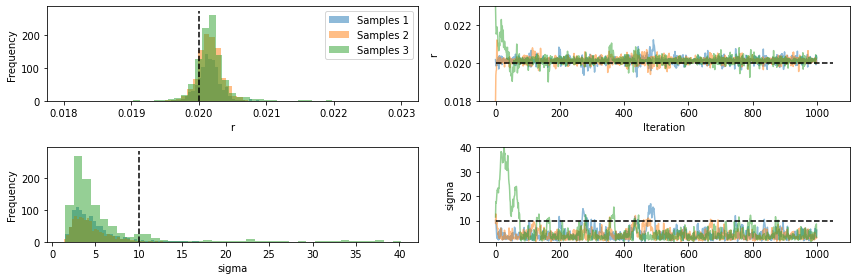

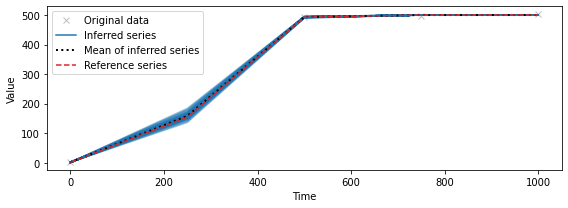

In [4]:
# Get true parameters
_, r, _, sigma = parameters[1]
true_params = np.array([r, sigma])

# Get log-likelihood and problem
log_likelihood = log_likelihoods[1]
problem = problems[1]

# Choose starting points for mcmc chains
xs = [
    true_params * 1.01,
    true_params * 0.9,
    true_params * 1.15,
]

# Set up MCMC routine
mcmc = pints.MCMCController(
    log_pdf=log_likelihood, 
    chains=len(xs),  # number of chains
    x0=xs,   # starting points
    method=pints.HamiltonianMCMC)

mcmc.set_max_iterations(1000)
mcmc.set_log_to_screen(False)
for s in mcmc.samplers():
    s.set_leapfrog_step_size(
        [2.020E-04, 1])

# Run
chains = mcmc.run()

# Show diagnostics
results = pints.MCMCSummary(chains=chains, time=mcmc.time(), parameter_names=['r', 'sigma'])
print(results)

pints.plot.trace(samples=chains, parameter_names=['r', 'sigma'], ref_parameters=true_params)
plt.show()

pints.plot.series(chains[0, 200:], problem, true_params)
plt.show()

**Figure 2:** Diagnostics of inference run independently for individual 2

## Pooling the noise parameter

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess     ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  ------  --------------
r1       0.02    0.00    0.01    0.01   0.02   0.02   0.02     1.01    445.62  14.68
r2       0.02    0.00    0.02    0.02   0.02   0.02   0.02     1.00    538.31  17.73
r3       0.01    0.00    0.01    0.01   0.01   0.01   0.01     1.00    535.33  17.63
r4       0.01    0.00    0.01    0.01   0.01   0.01   0.01     1.00    696.02  22.93
sigma    10.33   2.62    7.11    8.75   9.90   11.30  15.69    1.00    280.72  9.25


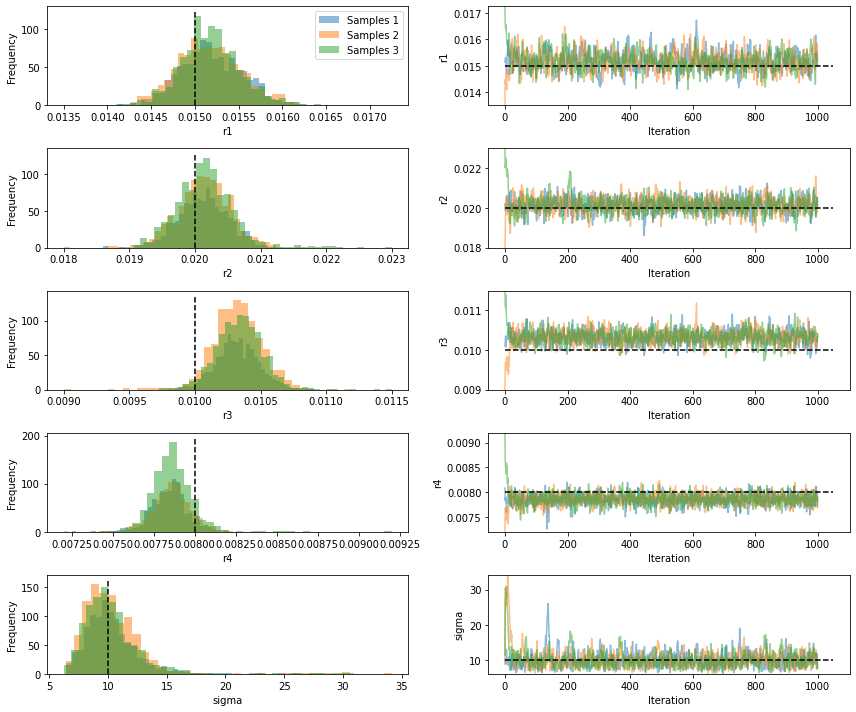

In [5]:
# Pool noise parameter
pooled_log_likelihood = pints.PooledLogPDF(log_likelihoods, [False, True])

# Get true parameters
_, r1, _, sigma = parameters[0]
_, r2, _, sigma = parameters[1]
_, r3, _, sigma = parameters[2]
_, r4, _, sigma = parameters[3]
true_params = np.array([r1, r2, r3, r4, sigma])

# Choose starting points for mcmc chains
xs = [
    true_params * 1.01,
    true_params * 0.9,
    true_params * 1.15,
]

# Set up MCMC routine
mcmc = pints.MCMCController(
    log_pdf=pooled_log_likelihood, 
    chains=len(xs),  # number of chains
    x0=xs,   # starting points
    method=pints.HamiltonianMCMC)

mcmc.set_max_iterations(1000)
mcmc.set_log_to_screen(False)
for s in mcmc.samplers():
    s.set_leapfrog_step_size(
        [1.515E-04, 2.020E-04, 1.010E-04, 8.080E-05, 1])

# Run
chains = mcmc.run()

# Show diagnostics
results = pints.MCMCSummary(chains=chains, time=mcmc.time(), parameter_names=['r1', 'r2', 'r3', 'r4', 'sigma'])
print(results)

pints.plot.trace(samples=chains, parameter_names=['r1', 'r2', 'r3', 'r4', 'sigma'], ref_parameters=true_params)
plt.show()

**Figure 3:** Diagnostics of inference run for pooled noise parameter across individuals.

We can see that the parameter inference hugely benefits from pooling the noise parameter across individuals. This is because the datasets for each individual are very sparse, and contain not enough information to identify the growth rate and the noise parameter. By pooling $\sigma $ the noise parameter learns from all data points across the individuals, which also helps the identifiability of the individual growth parameters.